# Mapping and Monitoring Drought
### Summary

Drought monitoring is critical for managing water resources, predicting agricultural productivity, and mitigating environmental impacts. Satellite-based data has emerged as a powerful tool for tracking precipitation patterns and assessing drought conditions in real-time. One widely used metric for this purpose is the **Standardized Precipitation Index (SPI)**, which quantifies drought severity based on historical precipitation data. By leveraging satellite-based precipitation measures, we can generate the SPI and apply it to map and monitor drought on various spatial and temporal scales.

This notebook provides an introduction to the SPI, demonstrates how to compute it using satellite precipitation data, and explores its application in drought monitoring.

### Learning Objectives
#### Overall goals 
The primary objective of this notebook is to demonstrate the use of satellite-based precipitation data (e.g., CHIRPS) to calculate indices like the Standardized Precipitation Index (SPI), enabling the quantification and characterization of drought conditions based on the SPI in a given region or country. 
#### Specific goals  
At the end of this notebook, you should have gained an understanding and appreciation of the following:

1. **Understand the Standardized Precipitation Index (SPI):**
   - Define SPI and explain its importance in drought assessment.
   - Describe how SPI is calculated and interpreted.

2. **Explore Satellite-Based Precipitation Data:**
   - Learn how to access and use satellite-based precipitation datasets.
   - Understand the advantages of satellite data for large-scale drought monitoring.

3. **Compute and Visualize SPI:**
   - Use satellite precipitation data to calculate SPI.
   - Visualize SPI maps and analyze drought conditions across different regions and timeframes.

4. **Apply SPI for Drought Monitoring:**
   - Identify drought trends and severity using the SPI.
   - Explore how SPI can inform decision-making in water resource management and agriculture. 

### Reference Materials
The materials presented in this notebook is built on top of the amazing work that the World Bank Data Lab has previously done in the [Morocco Economic Monitor Project](https://datapartnership.org/morocco-economic-monitor/README.html). Please refer to the repository for more details but specifically, please check the following:
- [Overview of satellite based monitoring of drought](https://datapartnership.org/morocco-economic-monitor/docs/drought-eo.html). This section includes an explanation of the SPI as a drought index, along with examples from Morocco.
- [SPI generation guide](https://datapartnership.org/morocco-economic-monitor/docs/drought-howto-spianalysis.html). This section offers a guide on how to utilize satellite precipitation estimates, such as [CHIRPS](https://chc.ucsb.edu/data/chirps), to generate the Standardized Precipitation Index (SPI)
- [Characterise drought using SPI](https://datapartnership.org/morocco-economic-monitor/docs/drought-howto-characteristics.html). This section explains how to develop meaningful metrics to characterize drought conditions using the Standardized Precipitation Index (SPI).

## Python Environment Setup (Optional)
### Required Python packages
In order to work and process precipitation and other geospatial data, we will need the following Python packages (All this assumes you have Python installed (e.g., through Anaconda)). `matplotlib`, `gdal`, `nco`, `cdo`, `netcdf4`, `pandas`, `geopandas`, `xarray`

### Python virtual environment 
To make things neat and easy, we can just create an environment
```python -m venv .venv-drought
    source .venv-drought/bin/activate
    pip install -U pip
    pip install -r requirements-drought.txt
```
### Notes on GDAL installation
Note that although you can pip install gdal, you need to have GDAL package installed first. There are several ways to do it but I recommend using "conda" as follows: ```conda install -c conda-forge gdal```

### Package for climate indices 
The [climate-indices](https://pypi.org/project/climate-indices/) python package enables the user to calculate SPI using any gridded netCDF dataset. You are required to install this using `pip install climate-indices`. However, there are certain specifications for input files that vary based on input type.

## Rainfall/Precipitation Data

### About Rainfall Data
SPI requires monthly rainfall data, and there are many source providing global high-resolution gridded monthly rainfall data:

- [CHIRPS](https://chc.ucsb.edu/data/chirps)
- [IMERG](https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGM_06/summary?keywords=IMERG)
- [FLDAS](https://disc.gsfc.nasa.gov/datasets/FLDAS_NOAH01_C_GL_M_001/summary?keywords=FLDAS)
- [TerraClimate](https://data.nkn.uidaho.edu/dataset/monthly-climate-and-climatic-water-balance-global-terrestrial-surfaces-1958-2015)
- [CRU](https://catalogue.ceda.ac.uk/uuid/89e1e34ec3554dc98594a5732622bce9)

In this notebook, we will work with the CHIRPS data.


### Downloading CHIRPS data

- We will download CHIRPS [monthly data in GeoTIFF](https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/tifs/) format and prepare it as input for SPI calculation.
- We will use either the wget or curl command to achieve this as below on the command line. 

```
mkdir CHIRPS
cd CHIRPS 

export URL='https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/tifs/'; curl "$URL" | grep -E 'a href=' | perl -pe 's|.*href="(.*?)".*|\1|' | { while read -r f; do wget "$URL"/"$f"; done }
```
- All CHIRPS monthly data is in GeoTIFF format from Jan 1981 to May 2023 (this is lot of data +-7GB zipped files, and become 27GB after extraction, please make sure you have bandwidth and unlimited data package). Paste and Enter below script in your Terminal.
- Gunzip all the downloaded files in the command line as follows: ```gunzip *.gz```

In [1]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
from shapely.geometry import mapping

import rasterio
from rasterio.features import geometry_mask

## 1.0 Generating SPI Index
We can summarize the steps involved in generating SPI indexing using CHIRPS data as follows:

1. **Prepare the input data.** These are initial preprocessing steps such as extracting just the region you are working on for the data.

2. **Calculate the SPI.** Calculate the indices on the terminal

3. **Review and update dimensions.** 

4. **Visualize the SPI.**

We will go through all of these steps in details in the following cells.

### 1.1 Preparing input data
#### General notes about units 
* Precipitation unit must be written as `millimeters`, `milimeter`, `mm`, `inches`, `inch` or `in`.

* Data dimension and order must be written as `lat`, `lon`, `time` (Windows machine required this order) or `time`, `lat`, `lon` (Works tested on Mac/Linux and Linux running on WSL).

* If your study area are big, it's better to prepare all the data following this dimension order: `lat`, `lon`, `time` as all the data will force following this order during SPEI calculation by NCO module. Let say you only prepare the data as is (leaving the order to `lat`, `lon`, `time`), it also acceptable but it will required lot of memory to use re-ordering the dimension, and usually NCO couldn't handle all the process and failed.
#### Clipping CHIRPS GeoTiffs to Area of interest (AOI)
Given that the raster files downloaded from CHIRPS are global, we need to clip the GeoTiffs only to the extent that we need. For example, Morocco. For this, we just need to have the the shapefile of the AOI to use for clipping.
#### Convert GeoTiff to NetCDF
In order to generate the SPI, we utulize the netCDF data format which we have mentioned before. The conversion between between geospatial data formats such as GeoTiff to NetCDF is not always easy. For this task, we will utilize the [convert GeoTiff to NetCDF](morocco-economic-monitor/src/datalab/climate-indices/geotiff-to-netcdf.py)


In [3]:
hex_color_codes = [
  '#a21fec' ,'#2a23eb', '#008180', '#00b44a', '#a2fd6e',
    '#ffffff', '#fefe53', '#fdd28a', '#ffa938', '#ec0013', '#760005'
]


In [4]:
def get_drought_class(value):
    if value <= -2.00:
        color_code = '#760005'
        rgb_code = 'rgb(118, 0, 5)'
        class_name = 'Exceptionally Dry'
    elif -2.00 <= value < -1.50:
        color_code = '#ec0013'
        rgb_code = 'rgb(236, 0, 19)'
        class_name = 'Extremely Dry'
    elif -1.50 <= value < -1.20:
        color_code = '#ffa938'
        rgb_code = 'rgb(255, 169, 56)'
        class_name = 'Severely Dry'
    elif -1.20 <= value < -0.70:
        color_code = '#fdd28a'
        rgb_code = 'rgb(253, 210, 138)'
        class_name = 'Moderately Dry'
    elif -0.70 <= value < -0.50:
        color_code = '#fefe53'
        rgb_code = 'rgb(254, 254, 83)'
        class_name = 'Abnormally Dry'
    elif -0.50 <= value < 0.50:
        color_code = '#ffffff'
        rgb_code = 'rgb(255, 255, 255)'
        class_name = 'Near Normal'
    elif 0.50 <= value < 0.70:
        color_code = '#a2fd6e'
        rgb_code = 'rgb(162, 253, 110)'
        class_name = 'Abnormally Moist'
    elif 0.70 <= value < 1.20:
        color_code = '#00b44a'
        rgb_code = 'rgb(0, 180, 74)'
        class_name = 'Moderately Moist'
    elif 1.20 <= value < 1.50:
        color_code = '#008180'
        rgb_code = 'rgb(0, 129, 128)'
        class_name = 'Very Moist'
    elif 1.50 <= value < 2.00:
        color_code = '#2a23eb'
        rgb_code = 'rgb(42, 35, 235)'
        class_name = 'Extremely Moist'
    elif value >= 2.00:
        color_code = '#a21fec'
        rgb_code = 'rgb(162, 31, 236)'
        class_name = 'Exceptionally Moist'
    else:
        color_code = None
        rgb_code = None
        class_name = None

    return color_code, rgb_code, class_name

## Visualizing Standardized Precipitation Index

In [5]:
ds = xr.open_mfdataset('../data/spi_output/mar_cli_chirps_spi_gamma_6_month.nc', parallel=True)
df = ds.to_dataframe().reset_index()
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df["lon"],df["lat"]))

In [6]:
gdf['class'] = gdf['spi_gamma_6_month'].apply(lambda x: get_drought_class(x)[2])

In [7]:
morocco_adm0 = geopandas.read_file('../data/shapefiles/mar_adm0.shp')
morocco_adm1 = geopandas.read_file('../data/shapefiles/mar_adm1.shp')
morocco_adm2 = geopandas.read_file('../data/shapefiles/mar_adm2.shp')

Assumptions 
* Remove all areas where spi is blank


In [8]:
def count_pixels_in_polygon(polygon, transform, shape):
    mask = geometry_mask([polygon], out_shape=shape, transform=transform, invert=False)
    return mask.sum()

# Loop through the GeoDataFrame rows and count pixels for each polygon

# adm 0 = 0.061
# adm1 = 

def get_pixel_count_for_polygon(gdf, resolution):
    pixel_counts = []
    for index, row in gdf.iterrows():
        polygon = row.geometry
        minx, miny, maxx, maxy = polygon.bounds
        x_res = y_res = resolution  # Adjust this based on your data
        shape = (int((maxy - miny) // y_res), int((maxx - minx) // x_res))
        transform = rasterio.transform.from_origin(minx, maxy, x_res, y_res)
        pixel_count = count_pixels_in_polygon(polygon, transform, shape)
        pixel_counts.append(pixel_count)

    # Add pixel counts as a new column in the GeoDataFrame
    gdf['pixel_count'] = pixel_counts

    return gdf


In [9]:
morocco_adm0 = get_pixel_count_for_polygon(morocco_adm0, 0.061)

In [10]:
# fivide by the sum total of all the pixels in morocco
gdf_adm0 = gdf.groupby(['class', 'time']).count()
gdf_adm0['percentage_area'] = 100*gdf_adm0['geometry']/16239

In [11]:
p = gdf_adm0.reset_index().set_index('time')[['class', 'percentage_area']].pivot_table(columns ='class', values='percentage_area', index = 'time')
p = p [[
    'Exceptionally Moist', 'Extremely Moist', 'Very Moist', 'Moderately Moist',
    'Abnormally Moist', 'Near Normal', 'Abnormally Dry', 'Moderately Dry',
    'Severely Dry', 'Extremely Dry', 'Exceptionally Dry'
]]

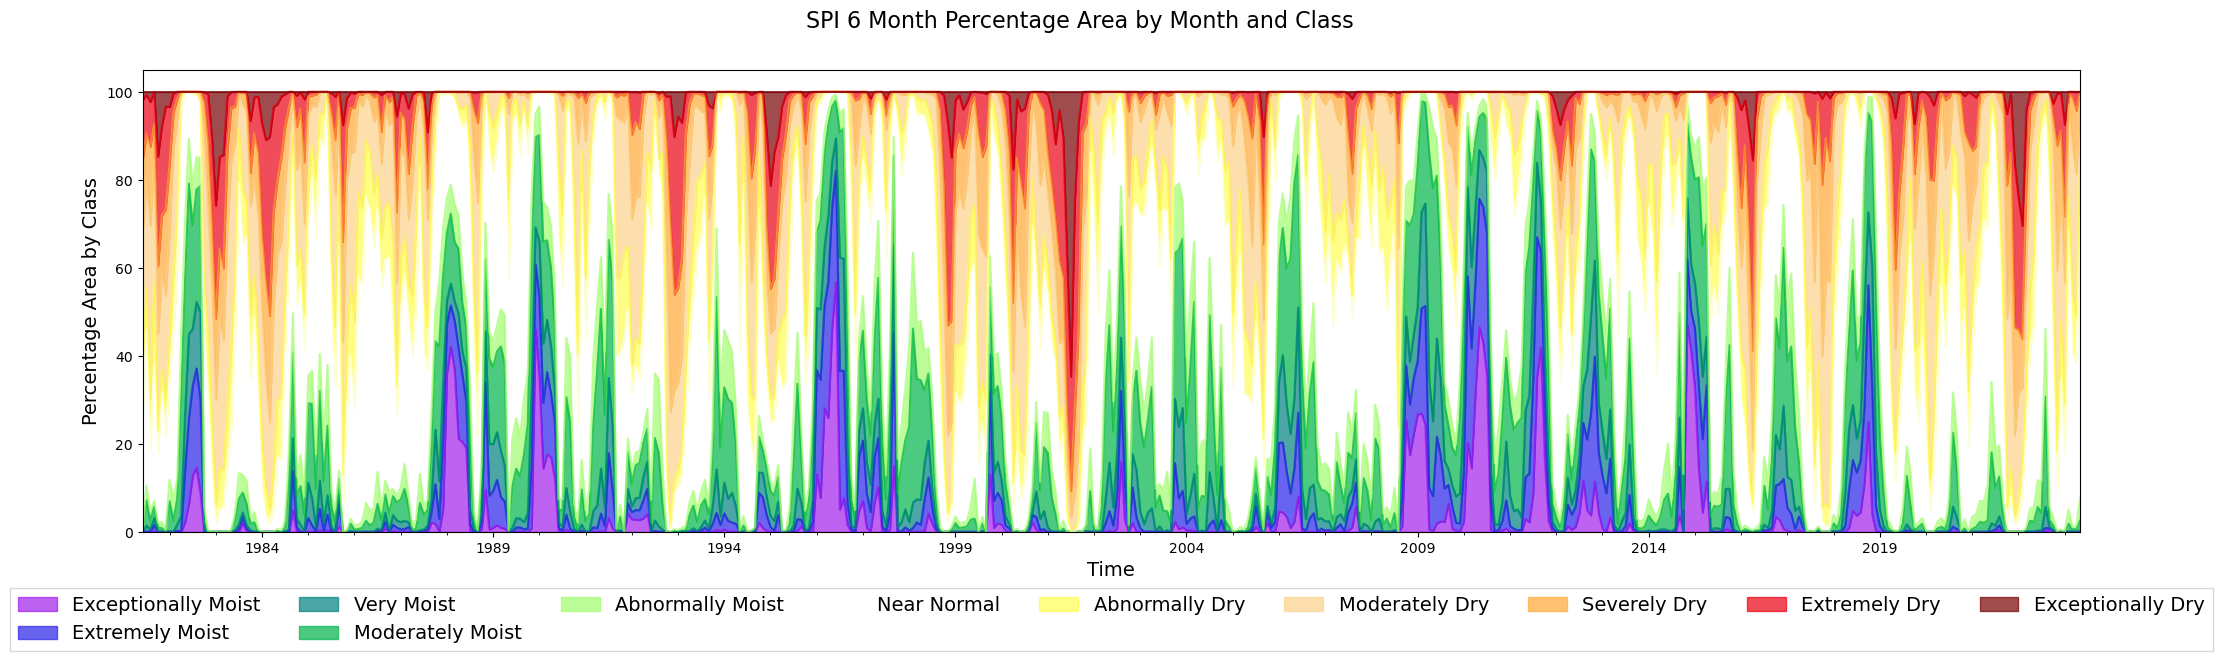

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25,6))


p.plot(kind='area', stacked=True, alpha = 0.7, color = hex_color_codes, ax=ax)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Percentage Area by Class', fontsize = 14)
ax.legend(title='Classes')

fig.suptitle('SPI 6 Month Percentage Area by Month and Class', fontsize=16)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=9, fontsize=14)

### Observations 
* The empty spaces are because of null values of SPI
* 2022, 2016, 2011-2002 were years of drought within Morocco

In [13]:
gdf_adm1 = morocco_adm1.sjoin(gdf)

c:\Users\sahit\anaconda3\envs\heatwaves\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [14]:
morocco_adm1 = get_pixel_count_for_polygon(morocco_adm1, 0.0436)

In [15]:
gdf_adm1 = gdf_adm1.groupby(['time', 'adm1_name', 'class']).count()

In [16]:
gdf_adm1 = gdf_adm1[['geometry']].reset_index()

In [17]:
gdf_adm1 = morocco_adm1[['adm1_name', 'pixel_count']].merge(gdf_adm1)
gdf_adm1.rename(columns = {'pixel_count':'adm_area', 'geometry':'class_area'}, inplace=True)
gdf_adm1['percentage_area'] = 100*gdf_adm1['class_area']/gdf_adm1['adm_area']

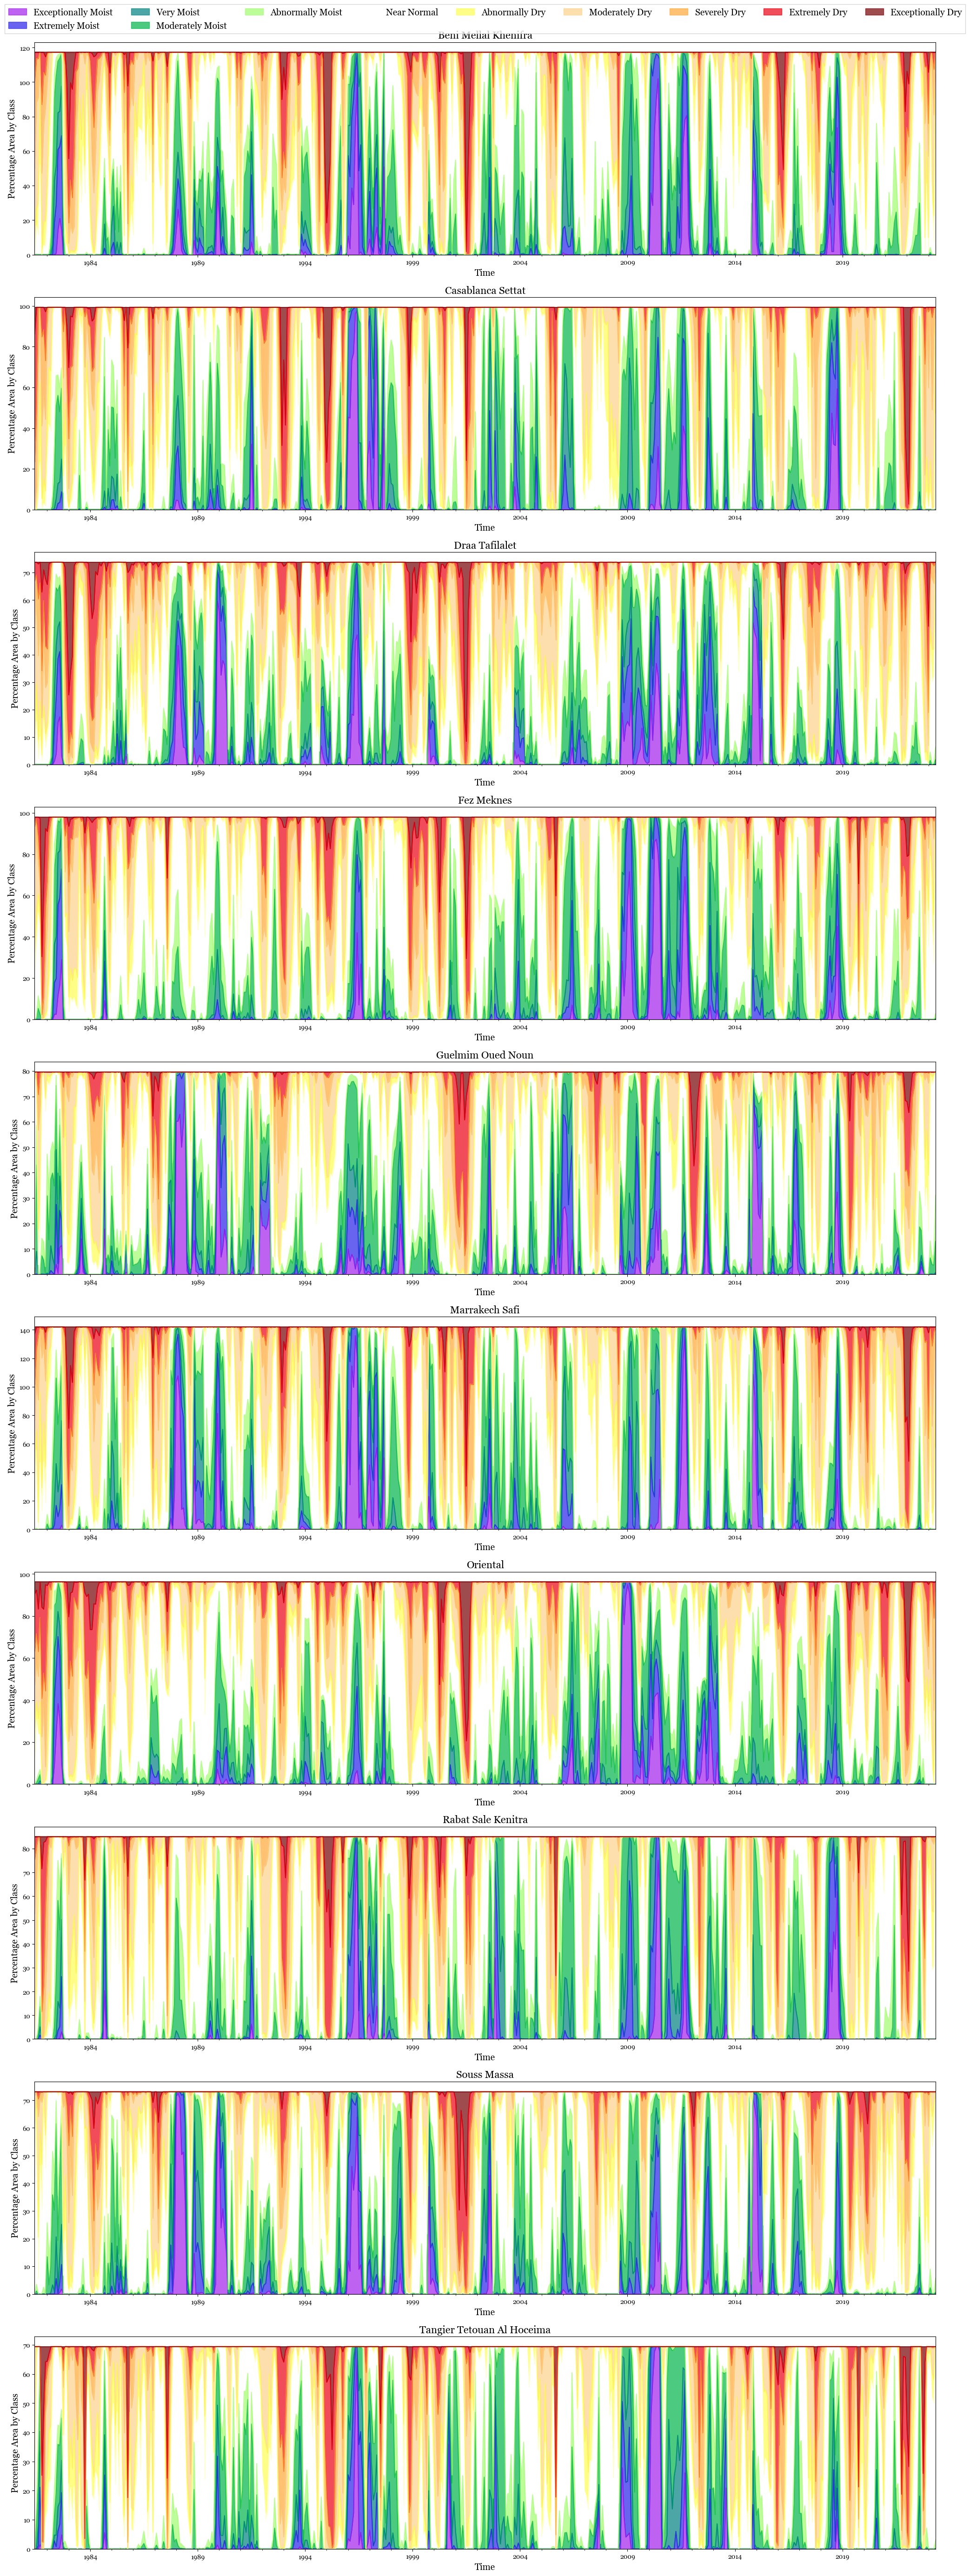

In [19]:
from matplotlib import rcParams

p = gdf_adm1[['adm1_name', 'time', 'percentage_area', 'class']]

rcParams['font.family'] = 'Georgia'
rcParams['font.sans-serif'] = ['Georgia']

fig, ax = plt.subplots(len(gdf_adm1['adm1_name'].unique()), 1, figsize=(25,70))

for i, adm in enumerate(gdf_adm1['adm1_name'].unique()):
    p1 = p[p['adm1_name']==adm]
    p1 = p1.reset_index().set_index('time')[['class', 'percentage_area']].pivot_table(columns ='class', values='percentage_area', index = 'time')
    p1 = p1 [[
     'Exceptionally Moist', 'Extremely Moist','Very Moist', 'Moderately Moist',
    'Abnormally Moist', 'Near Normal', 'Abnormally Dry', 'Moderately Dry',
    'Severely Dry', 'Extremely Dry', 'Exceptionally Dry']]

    p1.plot(kind='area', stacked=True, alpha = 0.7, color = hex_color_codes, ax=ax[i], legend = False)
    ax[i].set_xlabel('Time', fontsize=14)
    ax[i].set_ylabel('Percentage Area by Class', fontsize=14)
    #ax[i].legend(title='Categories')
    ax[i].set_title(adm, fontsize=16)
 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 12), fancybox=False, shadow=False, ncol=9, fontsize=14)

## Admin 1 regions in Dry Classes 

Dry Classes constitue of 'Abnormally Dry', 'Extremely Dry', 'Severely Dry', 'Exceptionally Dry'

In [23]:
gdf_adm1['class'].unique()

array(['Abnormally Dry', 'Extremely Dry', 'Moderately Dry', 'Near Normal',
       'Severely Dry', 'Exceptionally Dry', 'Abnormally Moist',
       'Moderately Moist', 'Very Moist', 'Extremely Moist',
       'Exceptionally Moist'], dtype=object)

In [20]:
extreme_dry_class = ['Abnormally Dry', 'Extremely Dry', 'Severely Dry', 'Exceptionally Dry']
moist_class = ['Abnormally Moist',
       'Moderately Moist', 'Very Moist', 'Extremely Moist',
       'Exceptionally Moist']

def get_class_type(x):
    if x in extreme_dry_class:
        return 'Dry Classes'
    elif x in moist_class:
        return 'Moist Classes'
    else:
        return 'Normal'

In [21]:
gdf_adm1['class_type'] = gdf_adm1['class'].apply(lambda x: get_class_type(x))

In [22]:
cmap = ['Reds', 'Greens', 'Greys']

Text(0.5, 0.98, 'Maximum Percentage Area in SPI 6 month Drought Classes in a year by Adm1 Regions')

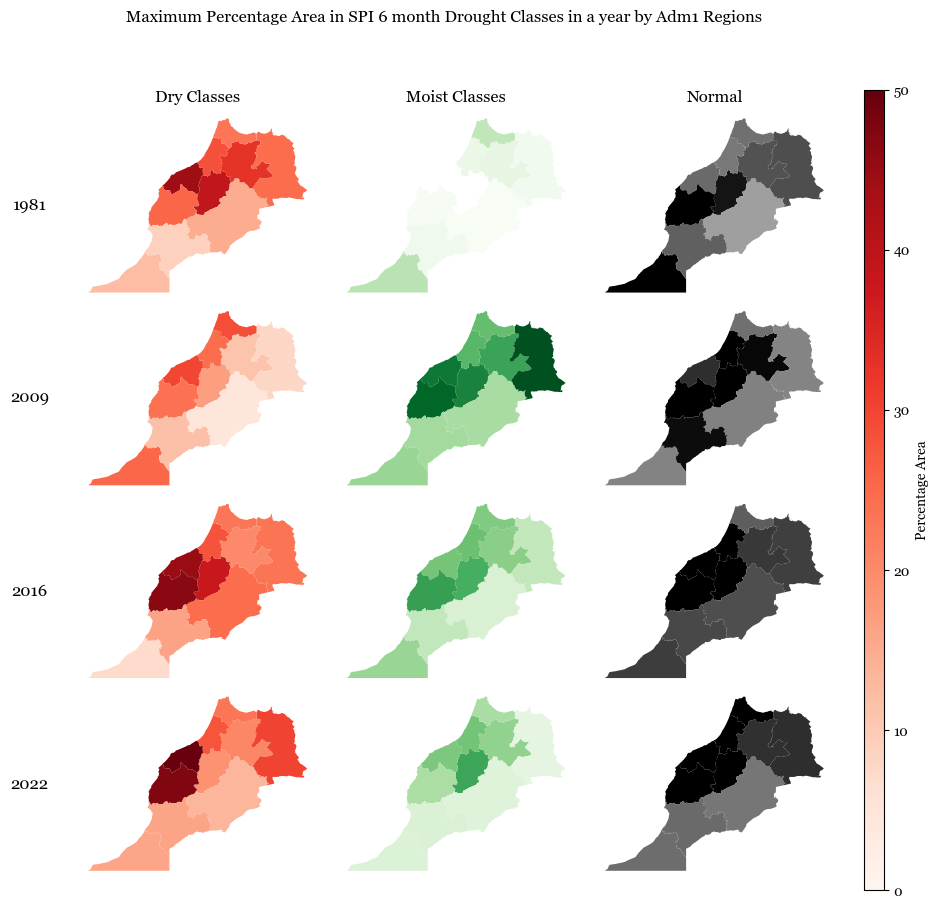

In [23]:
p = gdf_adm1.groupby(['adm1_name', 'class_type', 'time']).sum().reset_index()
p['percentage_area'] = 100*p['class_area']/p['adm_area']
p = p.groupby(['adm1_name', 'class_type', pd.Grouper(key='time', freq='Y')]).max().reset_index()
p = morocco_adm1[['adm1_name', 'geometry']].merge(p)
p = geopandas.GeoDataFrame(p, geometry='geometry')

fig, ax = plt.subplots(4,3, figsize=(10,10), sharex=True, sharey=True)

plots = []
for i, year in enumerate([1981, 2009, 2016, 2022]):
    p1 = p[p['time'].dt.year==year]
    ax[i][0].text(-0.2, 0.5, year, va='center', ha='center', fontsize=12,  transform=ax[i][0].transAxes,)
    for idx, class_type in enumerate(['Dry Classes', 'Moist Classes', 'Normal']):
        p2 = p1[p1['class_type']==class_type]
        plot = p2.plot(column='percentage_area',ax=ax[i][idx], cmap = cmap[idx], vmin=0, vmax=50)
        ax[i][idx].axis('off')
        plots.append(plot)
        ax[0][idx].set_title(class_type)
        #ax[idx][0].set_title(year)
    
    

cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust the position as needed
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=50))
sm.set_array([])  # Fake empty array for the colorbar
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Percentage Area')

plt.subplots_adjust(wspace=0.00005, hspace=0.005)

fig.suptitle('Maximum Percentage Area in SPI 6 month Drought Classes in a year by Adm1 Regions')


### Observations

The figure shows the maximum percentage area in each year that can be classified as dry, moist or normal based on the SPI classes i.e., it talks about the **worst months of drought or rainfall**. 

* 2009 was one of the years which was reltively moist 
* 2016 and 2022 were years with high dry conditions after 1981, as also validated by news outlets 
    * [2016 drought](https://thearabweekly.com/morocco-braces-drought-fallout)
    * [2022 drought](https://www.reuters.com/world/africa/morocco-spend-1-bln-mitigate-drought-impact-palace-2022-02-16/)


In [85]:
gdf_adm1.to_csv('../data/spi_class_adm1.csv')